
=== Processando: Sustentaveis === C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Sustentaveis_Degradacao_Linha.csv
Explained (primeiras dims): [0.215367   0.2035842  0.19812394]


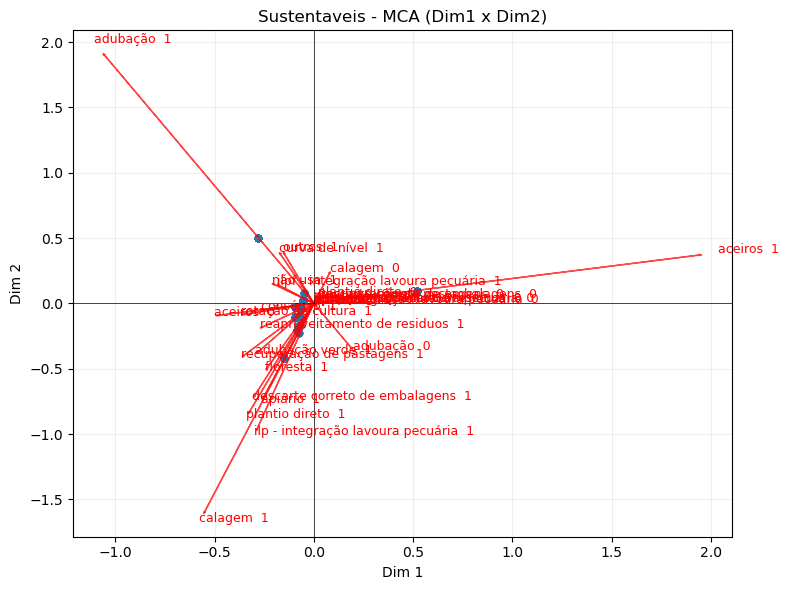

Silhouette (k=3): 0.835


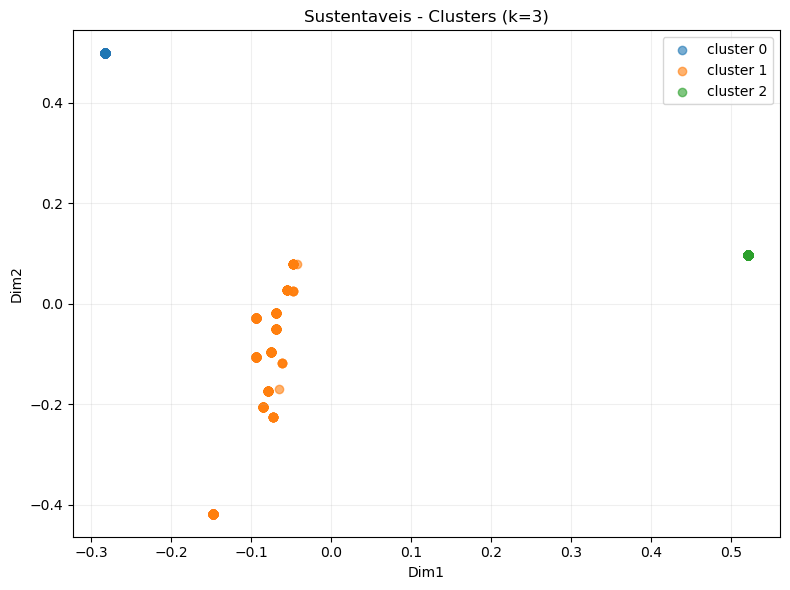

Erro ajustando OrderedModel: There should not be a constant in the model

=== Processando: Convencionais === C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Convencionais_Degradacao_Linha.csv
Explained (primeiras dims): [0.2119722  0.20683078 0.20157778]


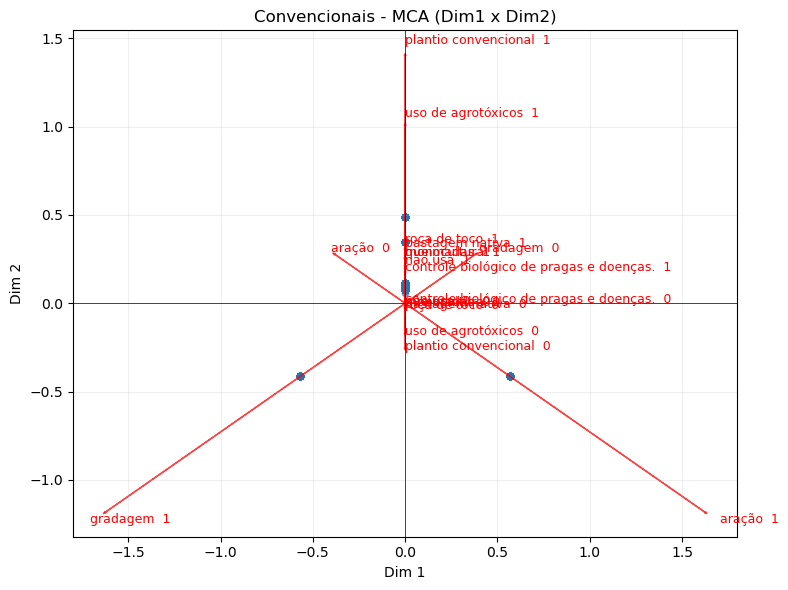

Silhouette (k=3): 0.872


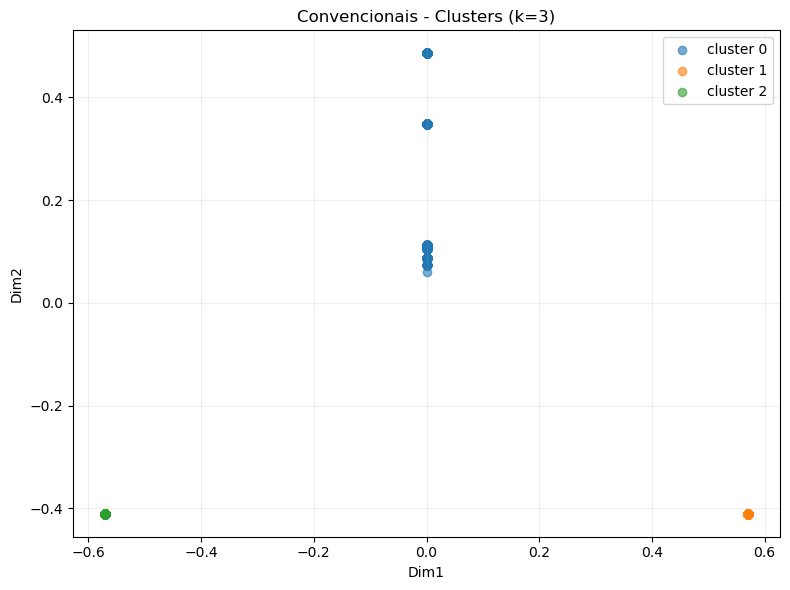

Erro ajustando OrderedModel: There should not be a constant in the model


In [7]:
# %% [markdown]
# # MCA, Cluster de Perfis e Regressão Ordinal
# - Aplica MCA em conjuntos: Práticas Sustentáveis e Práticas Convencionais (separadas)
# - Gera biplots, clusters (k-means) sobre componentes MCA
# - Usa componente 1 em modelo OrderedModel (regressão ordinal) com `degradacao_ord`
#
# Arquivos de entrada (confirmados):
# C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Sustentaveis_Degradacao_Linha.csv
# C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Convencionais_Degradacao_Linha.csv
#
# Variável dependente: degradacao_ord (0 = não possui degradação ... 3 = muito degradado)
# ------------------------------------------------------------------------------

# %% [markdown]
# ## 0. Instalação (executar no terminal do conda env se necessário)
# Se não tiver prince, execute no terminal:
# conda activate tocantins_env
# pip install prince scikit-learn matplotlib seaborn sklearn-extra
#
# (sklearn-extra contém KMedoids se quiser, mas usamos KMeans)
# ------------------------------------------------------------------------------

# %% [markdown]
# ## 1. Imports e configurações iniciais
# ------------------------------------------------------------------------------

# %%
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# statsmodels for ordinal model
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

# Try importing prince (MCA); if missing, we'll fallback to PCA on dummies
try:
    import prince
    HAVE_PRINCE = True
except Exception:
    HAVE_PRINCE = False
    print("Aviso: pacote 'prince' não encontrado. Usaremos fallback (PCA em matriz dummificada).")
    
# paths (ajuste se quiser)
path_sust = r"C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Sustentaveis_Degradacao_Linha.csv"
path_conv = r"C:/Users/Valentine/Artigo_Mapitos/data_clean/07_Codificado/07_Convencionais_Degradacao_Linha.csv"

out_dir = r"C:/Users/Valentine/Artigo_Mapitos/data_analysis/results_mca"
os.makedirs(out_dir, exist_ok=True)

# %% [markdown]
# ## 2. Funções utilitárias
# ------------------------------------------------------------------------------

# %%
def load_and_prep(path, prefix="pratica_"):
    """
    Carrega CSV e retorna:
    - df: dataframe completo
    - X: dataframe de dummies/praticas (somente colunas que contêm prefix)
    - y: degradacao_ord
    """
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower().str.strip()
    # ensure column names
    if "degradacao_ord" not in df.columns:
        raise KeyError("Coluna 'degradacao_ord' não encontrada no arquivo: " + path)
    # select practice columns (prefix)
    praticas = [c for c in df.columns if c.startswith(prefix)]
    if len(praticas) == 0:
        raise KeyError(f"Nenhuma coluna com prefixo '{prefix}' encontrada no arquivo: {path}")
    X = df[praticas].copy()
    # convert logical/trues to ints if necessary
    X = X.replace({True:1, False:0})
    y = df["degradacao_ord"].astype(int)
    return df, X, y

def do_mca(X, n_components=5):
    """
    Retorna: mca_object, row_coords (scores), col_coords (loadings), explained_inertia
    Usa prince.MCA se disponível; fallback para PCA sobre dummies (com centragem).
    """
    if HAVE_PRINCE:
        mca = prince.MCA(n_components=n_components, n_iter=5, copy=True, check_input=True, engine='sklearn')
        mca = mca.fit(X)
        row_coords = mca.row_coordinates(X)
        col_coords = mca.column_coordinates(X)
        # -----------------------------
        # INÉRCIA COMPATÍVEL COM TODAS AS VERSÕES DO PRINCE
        # -----------------------------
        if hasattr(mca, "explained_inertia_"):
            explained = mca.explained_inertia_
        elif hasattr(mca, "eigenvalues_"):
            # cálculo da proporção de inércia
            eig = np.array(mca.eigenvalues_)
            explained = eig / eig.sum()
        else:
            explained = np.array([])

        return mca, row_coords, col_coords, explained
    else:
        # Fallback: PCA on standardized indicator matrix
        scaler = StandardScaler(with_mean=True, with_std=False)  # center by column
        Xc = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        row_coords = pd.DataFrame(pca.fit_transform(Xc), index=X.index)
        # approximate col_coords via PCA components transposed
        col_coords = pd.DataFrame(pca.components_.T, index=X.columns)
        explained = pca.explained_variance_ratio_
        return pca, row_coords, col_coords, explained

def plot_biplot(row_coords, col_coords, labels=None, title="MCA biplot", dimx=0, dimy=1, figsize=(8,6), outpath=None):
    plt.figure(figsize=figsize)
    xs = row_coords.iloc[:, dimx]
    ys = row_coords.iloc[:, dimy]
    plt.scatter(xs, ys, s=20, alpha=0.6, label="observações")
    # label a few points? (avoid overcrowd)
    if labels is not None:
        # plot centroids - not labeling all points to avoid clutter
        pass
    # plot variable vectors (column coords)
    try:
        cc = col_coords.iloc[:, [dimx, dimy]]
        for i, (x,y) in enumerate(cc.values):
            plt.arrow(0,0,x,y, color='r', alpha=0.7, head_width=0.01)
            plt.text(x*1.05, y*1.05, cc.index[i].replace("pratica_","").replace("_"," "), color='r', fontsize=9)
    except Exception:
        pass
    plt.axhline(0, color='k', linewidth=0.5)
    plt.axvline(0, color='k', linewidth=0.5)
    plt.xlabel(f"Dim {dimx+1}")
    plt.ylabel(f"Dim {dimy+1}")
    plt.title(title)
    plt.grid(alpha=0.2)
    if outpath:
        plt.tight_layout()
        plt.savefig(outpath, dpi=300)
    plt.show()
    
def cluster_and_label(scores, n_clusters=3, random_state=42):
    k = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    labs = k.fit_predict(scores)
    sil = silhouette_score(scores, labs) if len(scores) > n_clusters else np.nan
    return labs, k, sil

# %% [markdown]
# ## 3. Pipeline MCA -> Clustering -> OrdinalModel para um dataset (função completa)
# ------------------------------------------------------------------------------

# %%
def run_pipeline(path, prefix="pratica_", label="Sustentaveis", n_mca=5, n_clusters=3, min_freq=5):
    print("\n=== Processando:", label, "===", path)
    df, X, y = load_and_prep(path, prefix=prefix)
    # remover praticas raras (opcional)
    freqs = X.sum().sort_values(ascending=False)
    keep = freqs[freqs >= min_freq].index.tolist()
    removed = freqs[freqs < min_freq].index.tolist()
    if removed:
        print("Removendo práticas raras (< {0}): {1}".format(min_freq, removed))
    Xk = X[keep].copy()
    
    # MCA
    mca_obj, row_coords, col_coords, explained = do_mca(Xk, n_components=n_mca)
    # garantir dataframes com nomes
    # garantir dataframes com nomes coerentes
    row_coords = pd.DataFrame(
        row_coords.values,
        index=df.index,
        columns=[f"Dim{i+1}" for i in range(row_coords.shape[1])]
    )

    # Aqui está a versão corrigida:
    col_coords = pd.DataFrame(
        col_coords.values,
        index=col_coords.index,  # <<< CORREÇÃO AQUI
        columns=[f"Dim{i+1}" for i in range(col_coords.shape[1])]
    )

    
    # salvar scores e loadings
    row_coords.to_csv(os.path.join(out_dir, f"{label}_mca_row_scores.csv"), index=True, encoding="utf-8-sig")
    col_coords.to_csv(os.path.join(out_dir, f"{label}_mca_col_coords.csv"), index=True, encoding="utf-8-sig")
    print("Explained (primeiras dims):", explained[:3])
    
    # plot biplot (Dim1 x Dim2)
    plot_biplot(row_coords, col_coords, title=f"{label} - MCA (Dim1 x Dim2)",
                outpath=os.path.join(out_dir, f"{label}_mca_biplot.png"))
    
    # cluster sobre Dim1/Dim2
    scores_12 = row_coords[["Dim1","Dim2"]].values
    best_k = n_clusters
    labs, kmodel, sil = cluster_and_label(scores_12, n_clusters=best_k)
    print("Silhouette (k={}): {:.3f}".format(best_k, sil))
    df[f"{label}_cluster"] = labs
    # salvar df com cluster e Dim1 col
    df_out = df.copy()
    df_out = pd.concat([df_out.reset_index(drop=True), row_coords.reset_index(drop=True)], axis=1)
    df_out.to_csv(os.path.join(out_dir, f"{label}_with_scores_clusters.csv"), index=False, encoding="utf-8-sig")
    
    # Plot clusters
    plt.figure(figsize=(8,6))
    palette = sns.color_palette("Set2", n_colors=best_k)
    for cl in np.unique(labs):
        mask = labs == cl
        plt.scatter(scores_12[mask,0], scores_12[mask,1], label=f"cluster {cl}", alpha=0.6)
    plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.legend(); plt.title(f"{label} - Clusters (k={best_k})")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{label}_clusters.png"), dpi=300)
    plt.show()
    
    # ---- Regressão ordinal: usar Dim1 como preditor (e opcionalmente n_praticas_total e regional)
    X_reg = pd.DataFrame({
        "dim1": row_coords["Dim1"],
        "n_praticas": Xk.sum(axis=1)
    }, index=row_coords.index)
    
    # align y (algumas linhas podem ter sido removidas? usamos index)
    y_reg = y.loc[X_reg.index].astype(int)
    X_reg = X_reg.astype(float)
    
    # fit OrderedModel
    try:
        model = OrderedModel(endog=y_reg, exog=X_reg, distr="logit")
        res = model.fit(method="bfgs", maxiter=300, disp=False)
        print(res.summary())
        # odds ratios
        or_df = pd.DataFrame({
            "coef": res.params,
            "se": res.bse,
            "pval": res.pvalues,
            "odds": np.exp(res.params)
        })
        or_df.to_csv(os.path.join(out_dir, f"{label}_ordinal_results.csv"), encoding="utf-8-sig")
        print("Resultados salvos em:", os.path.join(out_dir, f"{label}_ordinal_results.csv"))
    except Exception as e:
        print("Erro ajustando OrderedModel:", e)
        res = None
    
    return {
        "df": df,
        "X": Xk,
        "row_coords": row_coords,
        "col_coords": col_coords,
        "mca_obj": mca_obj,
        "clusters": labs,
        "kmodel": kmodel,
        "ordinal_res": res
    }

# %% [markdown]
# ## 4. Executar pipeline para SUSTENTÁVEIS e CONVENCIONAIS
# Ajuste n_clusters e min_freq conforme preferir.
# ------------------------------------------------------------------------------

# %%
res_sust = run_pipeline(path_sust, prefix="pratica_", label="Sustentaveis", n_mca=5, n_clusters=3, min_freq=1)
res_conv = run_pipeline(path_conv, prefix="pratica_", label="Convencionais", n_mca=5, n_clusters=3, min_freq=1)

# %% [markdown]
# ## 5. Análises post-hoc e plot de efeitos marginais (opcional)
# Gera diferença de probabilidade de estar em "muito degradado" (categoria 3)
# ao variar Dim1 do seu percentil 25 → 75.
# ------------------------------------------------------------------------------

# %%
def marginal_effects_on_high(res_model, X_reg, var="dim1"):
    if res_model is None:
        print("Modelo não disponível.")
        return
    # preparar dois perfis: 25% e 75% de var
    q25 = X_reg[var].quantile(0.25)
    q75 = X_reg[var].quantile(0.75)
    base = X_reg.mean().to_frame().T
    alt = base.copy()
    alt[var] = q75
    probs_base = res_model.predict(exog=base)[0]
    probs_alt = res_model.predict(exog=alt)[0]
    # prob category 3 (index -1)
    delta_high = probs_alt[-1] - probs_base[-1]
    print(f"Delta prob (categoria mais alta) ao aumentar {var} de média -> 75pct: {delta_high:.4f}")
    return probs_base, probs_alt, delta_high

# exemplo para sustentaveis
if res_sust["ordinal_res"] is not None:
    df_sust_reg = pd.read_csv(os.path.join(out_dir, "Sustentaveis_with_scores_clusters.csv"))
    X_reg_sust = pd.DataFrame({
        "dim1": df_sust_reg["Dim1"],
        "n_praticas": df_sust_reg[[c for c in df_sust_reg.columns if c.startswith("pratica_")]].sum(axis=1)
    })
    marginal_effects_on_high(res_sust["ordinal_res"], X_reg_sust, var="dim1")

# %% [markdown]
# ## 6. Saídas geradas
# - Sustentaveis_mca_row_scores.csv
# - Sustentaveis_mca_col_coords.csv
# - Sustentaveis_mca_biplot.png
# - Sustentaveis_clusters.png
# - Sustentaveis_with_scores_clusters.csv
# - Sustentaveis_ordinal_results.csv
# (mesmos para Convencionais)
# ------------------------------------------------------------------------------

# %% [markdown]
# ## Observações de interpretação (leia após rodar)
# - Examine o biplot para entender que práticas carregam Dim1 (use col_coords).
# - Se Dim1 correlaciona com práticas "convencionais intensivas" -> espera-se coef positivo com degradacao.
# - Se Dim1 correlaciona com práticas "sustentaveis" -> espera-se coef negativo com degradacao.
# - O indicador `n_praticas` ajuda a separar efeito de intensidade vs. tipo de manejo.
# - Se modelos não convergirem, aumente `min_freq` (remova variáveis raras) ou use apenas Dim1 (apenas 1 preditor).
# ------------------------------------------------------------------------------

